In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import f_oneway, normaltest
from scipy.stats import pearsonr
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu
import math
from scipy import stats
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib.patches import Ellipse, Polygon

In [2]:
FOLDER = 'Logs'
files = os.listdir(FOLDER)

#headings = list(filter(lambda x: 'headings' in x and not 'old' in x, files))
headings = list(filter(lambda x: 'headings' in x, files))
headings_csv = [pd.read_csv(os.path.join(FOLDER, x)) for x in headings]

#positions = list(filter(lambda x: 'position' in x and not 'old' in x, files))
positions = list(filter(lambda x: 'position' in x, files))
positions_csv = [pd.read_csv(os.path.join(FOLDER, x)) for x in positions]

In [3]:
headings_0 = list(filter(lambda x: 'headings' in x and '_0.' in x, files))
headings_1 = list(filter(lambda x: 'headings' in x and '_1.' in x, files))
headings_2 = list(filter(lambda x: 'headings' in x and '_2.' in x, files))
headings_csv_0 = [pd.read_csv(os.path.join(FOLDER, x)) for x in headings_0]
headings_csv_1 = [pd.read_csv(os.path.join(FOLDER, x)) for x in headings_1]
headings_csv_2 = [pd.read_csv(os.path.join(FOLDER, x)) for x in headings_2]

positions_0 = list(filter(lambda x: 'position' in x and '_0.' in x, files))
positions_1 = list(filter(lambda x: 'position' in x and '_1.' in x, files))
positions_2 = list(filter(lambda x: 'position' in x and '_2.' in x, files))
positions_csv_0 = [pd.read_csv(os.path.join(FOLDER, x)) for x in positions_0]
positions_csv_1 = [pd.read_csv(os.path.join(FOLDER, x)) for x in positions_1]
positions_csv_2 = [pd.read_csv(os.path.join(FOLDER, x)) for x in positions_2]

In [4]:
headings_0

['RTI_Class_headings_Lena_33_F_0.csv',
 'RTI_Class_headings_Gina_36_F_0.csv',
 'RTI_Class_headings_DavidF_25_M_0.csv',
 'RTI_Class_headings_Sara_23_F_old_0.csv',
 'RTI_Class_headings_Alex_26_M_0.csv',
 'RTI_Class_headings_SmrtSapiens_23_M_0.csv',
 'RTI_Class_headings_Jonas_30_M_0.csv',
 'RTI_Class_headings_NataliaM_25_F_old_0.csv',
 'RTI_Class_headings_Cesc_25_M_old_0.csv',
 'RTI_Class_headings_Alex_24_M_old_0.csv']

In [5]:
positions_0

['RTI_Class_positions_NataliaM_25_F_old_0.csv',
 'RTI_Class_positions_Lena_33_F_0.csv',
 'RTI_Class_positions_Gina_36_F_0.csv',
 'RTI_Class_positions_Sara_23_F_old_0.csv',
 'RTI_Class_positions_Alex_26_M_0.csv',
 'RTI_Class_positions_DavidF_25_M_0.csv',
 'RTI_Class_positions_Jonas_30_M_0.csv',
 'RTI_Class_positions_Cesc_25_M_old_0.csv',
 'RTI_Class_positions_SmrtSapiens_23_M_0.csv',
 'RTI_Class_positions_Alex_24_M_old_0.csv']

In [6]:
types = []
errs = []
times = []
times_return = []
return_rates = [] 

for h, name in zip(positions_csv[:], positions[:]):
    h = h.dropna(axis=0)
    split_idx = h[h.progress == 0].index[-1] + 3
    exp_type = name.replace('_old', '').split('_')[-1].replace('.csv', '')
    
    time = h['time'].iloc[-1]
    return_time = h.time.iloc[-1] - h.loc[split_idx].time
    return_rate = return_time/time

    x0 = h.x.iloc[0]
    x1 = h.x.iloc[-1]
    z0 = h.z.iloc[0]
    z1 = h.z.iloc[-1]
    
    error = np.sqrt(np.power(x1 - x0, 2) + \
                np.power(z1- z0, 2))
    
    print(exp_type, 
          #'-->', np.round(return_time,2), 
          '-->', np.round(return_rate,2), 
          '-->', np.round(error,2))
    
    types.append(exp_type)
    errs.append(error)
    times.append(time)
    times_return.append(return_time)
    return_rates.append(return_rate)

1 --> 0.56 --> 53.82
0 --> 0.66 --> 147.95
2 --> 0.25 --> 9.09
2 --> 0.5 --> 21.61
0 --> 0.2 --> 7.14
0 --> 0.49 --> 45.04
0 --> 0.32 --> 8.65
0 --> 0.67 --> 214.43
2 --> 0.53 --> 8.58
1 --> 0.29 --> 14.63
2 --> 0.29 --> 30.36
1 --> 0.32 --> 5.53
0 --> 0.32 --> 135.52
1 --> 0.39 --> 39.93
2 --> 0.37 --> 8.37
0 --> 0.39 --> 11.74
2 --> 0.31 --> 9.74
2 --> 0.48 --> 21.13
0 --> 0.39 --> 43.61
1 --> 0.42 --> 31.68
1 --> 0.49 --> 23.46
1 --> 0.54 --> 37.84
0 --> 0.22 --> 42.71
1 --> 0.43 --> 57.33
1 --> 0.28 --> 50.46
0 --> 0.26 --> 24.46
2 --> 0.23 --> 36.65
2 --> 0.26 --> 21.27


In [7]:
color_dict = {'0': 'orange','1': 'teal','2': 'yellowgreen'}

def plot_path(exp_type):
    
    plt.figure(figsize=(6, 6))
    plt.axis('equal')
    plt.xlim(-220, 180)
    plt.ylim(-100, 300)
    
    csv_list = []
    file_list = []
    
    if (exp_type == '0'): 
        plt.title('Chosen Path - Disorientation')
        csv_list = positions_csv_0[:]
        file_list = positions_0[:]
    elif (exp_type == '1'): 
        plt.title('Chosen Path - No Landmarks')
        csv_list = positions_csv_1[:]
        file_list = positions_1[:]
    elif (exp_type == '2'): 
        plt.title('Chosen Path - Control')
        csv_list = positions_csv_2[:]
        file_list = positions_2[:]
    
    for h, name in zip(csv_list, file_list):
        h = h.dropna(axis=0)
        split_idx = h[h.progress == 0].index[-1] + 3

        plt.plot(h.iloc[:split_idx].x,
                 h.iloc[:split_idx].z,
                 c=color_dict[exp_type], ls=':', alpha=0.8, label='Finding')

        plt.plot(h.iloc[split_idx:].x,
                 h.iloc[split_idx:].z,
                 c=color_dict[exp_type], ls='solid', alpha=1, label='Homing')

        x0 = h.x.iloc[0]
        x1 = h.x.iloc[-1]
        z0 = h.z.iloc[0]
        z1 = h.z.iloc[-1]
        plt.plot([x0, x1], [z0, z1], c='red', marker='*')

    #handles, labels = plt.gca().get_legend_handles_labels()
    #by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys())
    #plt.legend()

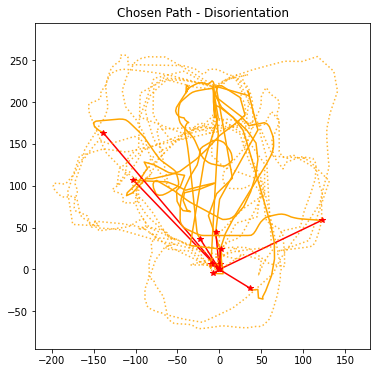

In [8]:
plot_path('0')

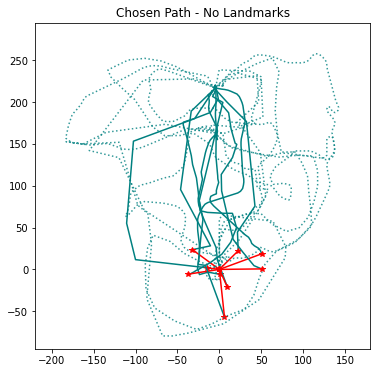

In [9]:
plot_path('1')

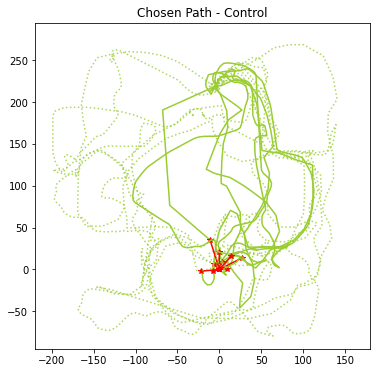

In [10]:
plot_path('2')

In [11]:
d_points = {'0': [],
            '1': [],
            '2': []}

def plot_error(exp_type):
    
    plt.figure(figsize=(6, 6))
    plt.axis('equal')
    plt.xlim(-200, 180)
    plt.ylim(-100, 300)
    
    csv_list = []
    file_list = []
    
    if (exp_type == '0'): 
        plt.title('Error - Disorientation')
        csv_list = positions_csv_0[:]
        file_list = positions_0[:]
    elif (exp_type == '1'): 
        plt.title('Error - No Landmarks')
        csv_list = positions_csv_1[:]
        file_list = positions_1[:]
    elif (exp_type == '2'): 
        plt.title('Error - Control')
        csv_list = positions_csv_2[:]
        file_list = positions_2[:]
    
    for h, name in zip(csv_list, file_list):
        h = h.dropna(axis=0)
        split_idx = h[h.progress == 0].index[-1] + 3

        x0 = h.x.iloc[0]
        x1 = h.x.iloc[-1]
        z0 = h.z.iloc[0]
        z1 = h.z.iloc[-1]
        plt.scatter([x1], [z1], s=80, c=color_dict[exp_type], marker='*', label='Estimated home')
        d_points[exp_type].append((x1, z1))
        
    plt.scatter(x0, z0, marker='d', s=80, c='red', label='Home')
    plt.scatter(h.iloc[split_idx].x, h.iloc[split_idx].z, s=80, c='blue', marker='x', label='Target')
    points = np.array(d_points[exp_type])
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color='grey', ls='--')
    print(points[simplex, 0])
    print(hull.simplices)
    print(hull.area)

    #handles, labels = plt.gca().get_legend_handles_labels()
    #by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys())
    #plt.legend()

[-102.6005     -7.159372]
[[5 4]
 [7 5]
 [3 7]
 [0 4]
 [0 3]]
660.9053654474716


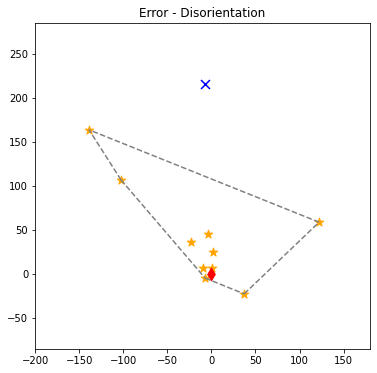

In [12]:
plot_error('0')

[ 22.54135 -32.21766]
[[7 6]
 [3 6]
 [8 0]
 [8 7]
 [4 0]
 [4 3]]
270.678099999486


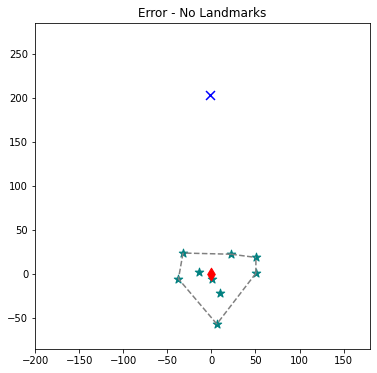

In [13]:
plot_error('1')

[-8.05118   9.060065]
[[7 1]
 [7 3]
 [0 3]
 [4 1]
 [4 0]]
135.1483840586339


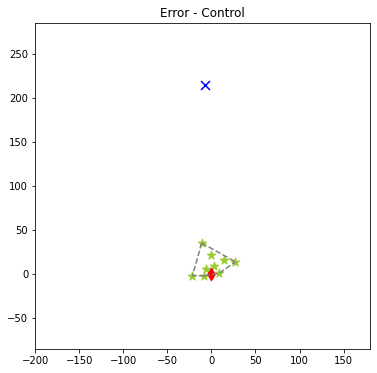

In [14]:
plot_error('2')

In [15]:
results = pd.DataFrame(np.array([types, errs, times, times_return, return_rates]).astype(np.float32).T,
                       columns=['group', 'err', 'time', 'return_time', 'return_rate'])

In [16]:
results

,group,err,time,return_time,return_rate
0,1.0,53.817543,54.183830,30.381491,0.560711
1,0.0,147.946487,121.001900,80.013031,0.661254
2,2.0,9.089354,150.983795,36.996300,0.245035
3,2.0,21.611198,64.986214,32.787601,0.504532
4,0.0,7.135922,140.793106,28.803200,0.204578
5,0.0,45.038258,69.610878,34.005970,0.488515
6,0.0,8.647261,78.993942,25.003611,0.316526
7,0.0,214.428223,58.784901,39.188709,0.666646
8,2.0,8.576839,55.000011,29.011570,0.527483
9,1.0,14.630140,167.984604,49.000599,0.291697


In [17]:
results.groupby('group').count()

,err,time,return_time,return_rate
group,,,,
0.0,10,10,10,10
1.0,9,9,9,9
2.0,9,9,9,9


In [18]:
results.groupby('group')['time'].mean()

group
0.0    100.097801
1.0     93.819046
2.0    107.910316
Name: time, dtype: float32

In [19]:
results.groupby('group')['return_time'].mean()

group
0.0    37.000549
1.0    37.202175
2.0    35.670021
Name: return_time, dtype: float32

In [20]:
results.groupby('group')['return_time'].std()

group
0.0    16.153477
1.0    14.228909
2.0     7.460892
Name: return_time, dtype: float64

In [21]:
results.groupby('group')['return_rate'].mean()

group
0.0    0.392145
1.0    0.413367
2.0    0.357212
Name: return_rate, dtype: float32

In [22]:
results.groupby('group')['return_rate'].std()

group
0.0    0.166430
1.0    0.103408
2.0    0.116906
Name: return_rate, dtype: float64

In [23]:
results.groupby('group')['err'].mean()

group
0.0    68.123169
1.0    34.964016
2.0    18.532825
Name: err, dtype: float32

In [24]:
results.groupby('group')['err'].std()

group
0.0    71.834226
1.0    17.860928
2.0    10.371342
Name: err, dtype: float64

In [25]:
g0 = results[results['group'] == 0]
g1 = results[results['group'] == 1]
g2 = results[results['group'] == 2]

In [26]:
#print(normaltest(g0['return_time']))
#print(normaltest(g1['return_time']))
#print(normaltest(g2['return_time']))

print(f_oneway(g0['return_time'], g1['return_time'], g2['return_time']))

F_onewayResult(statistic=0.03572020467779292, pvalue=0.9649593871544948)


In [27]:
print(pearsonr(g0['time'], g0['err']))
print(pearsonr(g1['time'], g1['err']))
print(pearsonr(g2['time'], g2['err']))

(-0.1425531762963069, 0.6944249632895596)
(-0.5305557989543263, 0.1416902995434301)
(0.187423460249606, 0.6291850091508909)


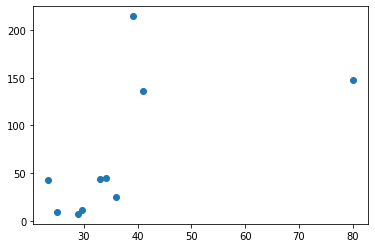

In [28]:
plt.scatter(g0['return_time'], g0['err'])

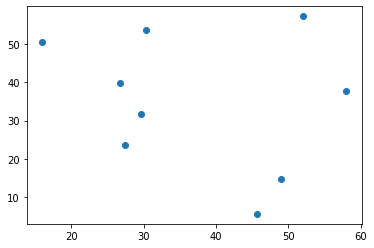

In [29]:
plt.scatter(g1['return_time'], g1['err'])

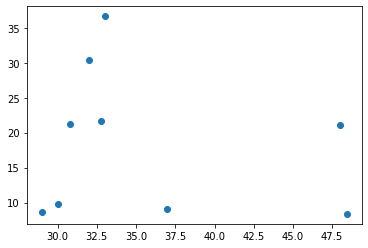

In [30]:
plt.scatter(g2['return_time'], g2['err'])

{'whiskers': [<matplotlib.lines.Line2D at 0x124a90cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x124aa02b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x124a90a58>,
 'medians': [<matplotlib.lines.Line2D at 0x124aa0860>,
 'fliers': [<matplotlib.lines.Line2D at 0x124aa0b38>,
 'means': []}

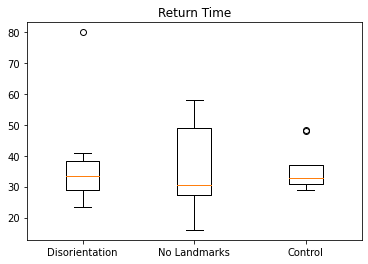

In [33]:
plt.title('Return Time')
plt.boxplot([g0['return_time'], g1['return_time'], g2['return_time']], 
            labels=['Disorientation', 'No Landmarks', 'Control'])

In [34]:
#print(normaltest(g0['return_rate']))
#print(normaltest(g1['return_rate']))
#print(normaltest(g2['return_rate']))

print(f_oneway(g0['return_rate'], g1['return_rate'], g2['return_rate']))

F_onewayResult(statistic=0.4078417054659514, pvalue=0.6694293931550186)


{'whiskers': [<matplotlib.lines.Line2D at 0x124c8a160>,
 'caps': [<matplotlib.lines.Line2D at 0x124c8a710>,
 'boxes': [<matplotlib.lines.Line2D at 0x124c1beb8>,
 'medians': [<matplotlib.lines.Line2D at 0x124c8acc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x124c8af98>,
 'means': []}

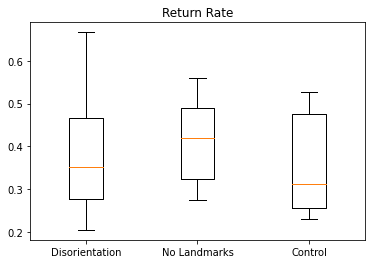

In [36]:
plt.title('Return Rate')
plt.boxplot([g0['return_rate'], g1['return_rate'], g2['return_rate']], 
            labels=['Disorientation', 'No Landmarks', 'Control'])

In [37]:
#print(normaltest(g0['err']))
#print(normaltest(g1['err']))
#print(normaltest(g2['err']))

print(f_oneway(g0['err'], g1['err'], g2['err']))

F_onewayResult(statistic=3.0638965749464857, pvalue=0.06454995746903675)


{'whiskers': [<matplotlib.lines.Line2D at 0x124d98198>,
 'caps': [<matplotlib.lines.Line2D at 0x124d98748>,
 'boxes': [<matplotlib.lines.Line2D at 0x124d8bef0>,
 'medians': [<matplotlib.lines.Line2D at 0x124d98cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x124d98f60>,
 'means': []}

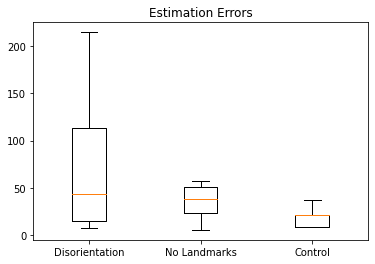

In [38]:
plt.title('Estimation Errors')
plt.boxplot([g0['err'], g1['err'], g2['err']], 
            labels=['Disorientation', 'No Landmarks', 'Control'])

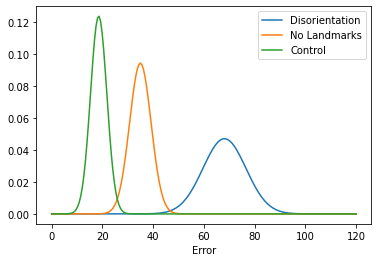

In [40]:
for g, n in zip([g0, g1, g2], ['Disorientation', 'No Landmarks', 'Control']):
    mu = g['err'].mean()
    variance = g['err'].std()
    sigma = math.sqrt(variance)
    x = np.linspace(0, 120, 200)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=n)
plt.xlabel('Error')
plt.legend()

In [42]:
g0['err']

1     147.946487
4       7.135922
5      45.038258
6       8.647261
7     214.428223
12    135.518066
15     11.737762
18     43.609173
22     42.714279
25     24.456274
Name: err, dtype: float32

In [43]:
g1['err']

0     53.817543
9     14.630140
11     5.525801
13    39.930580
19    31.675276
20    23.460749
21    37.843102
23    57.331455
24    50.461506
Name: err, dtype: float32

In [44]:
g2['err']

2      9.089354
3     21.611198
8      8.576839
10    30.356682
14     8.370060
16     9.743195
17    21.134937
26    36.648048
27    21.265123
Name: err, dtype: float32

In [45]:
mannwhitneyu(g0['err'].iloc[1:], g1['err'].iloc[1:])

MannwhitneyuResult(statistic=32.0, pvalue=0.3681384891705356)

In [46]:
h = headings_csv[8]

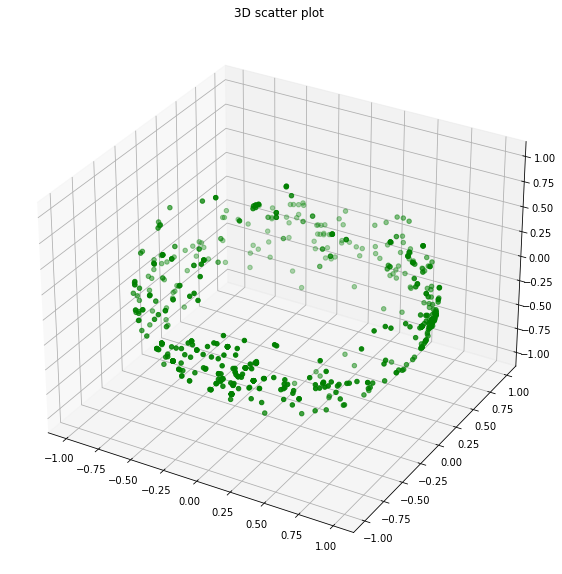

In [47]:
# Creating figure
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(h.z, h.x, h.y, color = "green")
plt.title("3D scatter plot")
 
# show plot
plt.show()

Text(0.5, 1.0, 'Y-Z axes')

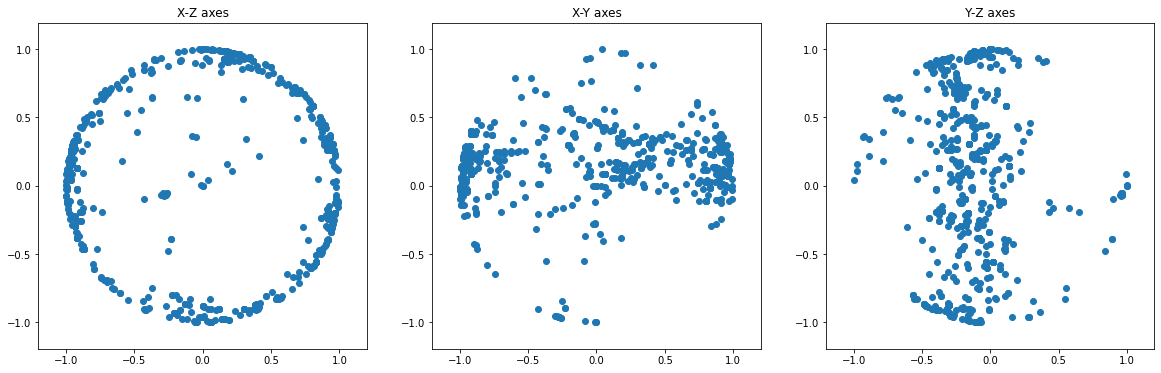

In [48]:
lim = 1.2
plt.figure(figsize=(20, 6))
    
plt.subplot(131)
plt.axis('equal')
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.scatter(h.x, h.z)
plt.title("X-Z axes")

plt.subplot(132)
plt.axis('equal')
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.scatter(h.x, -h.y)
plt.title("X-Y axes")

plt.subplot(133)
plt.axis('equal')
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.scatter(h.y, h.z)
plt.title("Y-Z axes")

Text(0.5, 1.0, 'Y-Z axes')

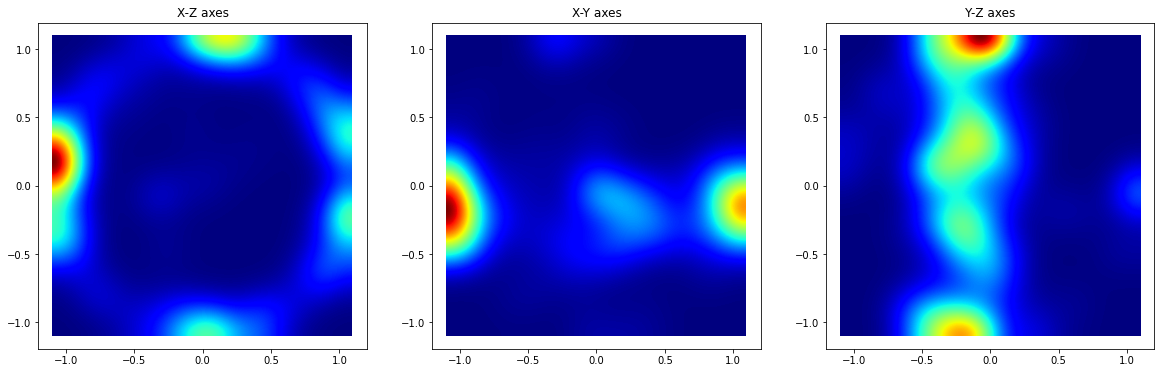

In [54]:
def heading_heatmap(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    margin = 0.1
    extent = [xedges[0] - margin, xedges[-1] + margin, yedges[0] - margin, yedges[-1] + margin]
    return heatmap.T, extent

plt.figure(figsize=(20, 6))
    
plt.subplot(131)
plt.axis('equal')
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
img, extent = heading_heatmap(h.x, h.z, 64)
plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
plt.title("X-Z axes")

plt.subplot(132)
plt.axis('equal')
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
img, extent = heading_heatmap(h.x, h.y, 64)
plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
plt.title("X-Y axes")

plt.subplot(133)
plt.axis('equal')
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
img, extent = heading_heatmap(h.y, h.z, 64)
plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
plt.title("Y-Z axes")

In [55]:
def cart_to_spherical(x, y, z):
    theta = np.arctan(np.sqrt(x**2 + y**2)/z)
    phi = np.arctan2(y, x)
    return theta, phi

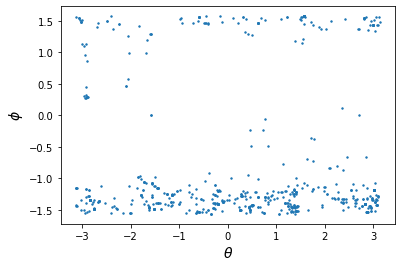

In [61]:
theta, phi = cart_to_spherical(h.x, h.z, h.y)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\phi$', fontsize=14)

plt.scatter(phi, theta, s=2)

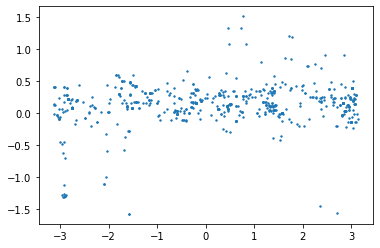

In [60]:
plt.scatter(phi, (theta + np.pi/2 + np.pi/2) % np.pi - np.pi/2, s=2)

In [56]:
def spherical_to_cart(p, t):
    x = np.cos(t)*np.sin(p)
    y = np.sin(t)*np.sin(p)
    z = np.cos(p)
    return x, y, z

In [57]:
def calculate_entropy(x, y, z, bins=300, s=40):
    t, p = cart_to_spherical(x, y, z)
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    return stats.entropy(heatmap.ravel())

2 --> 11.05


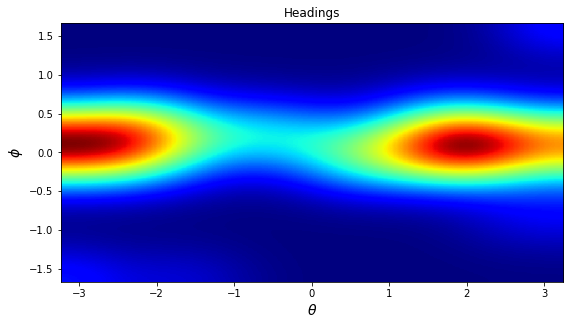

0 --> 10.76


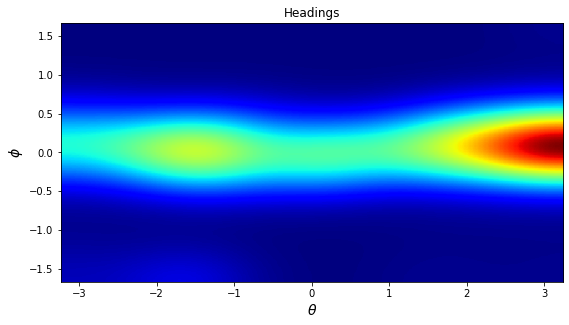

0 --> 11.1


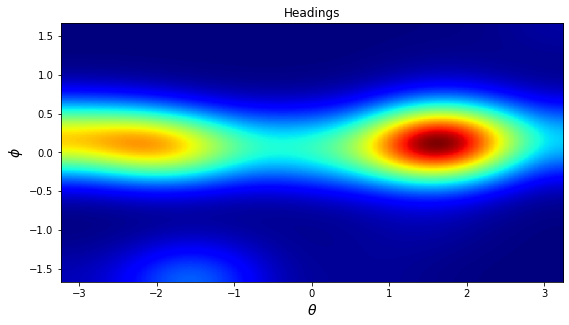

2 --> 10.7


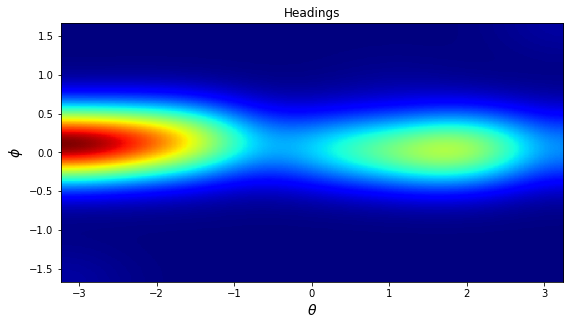

0 --> 11.23


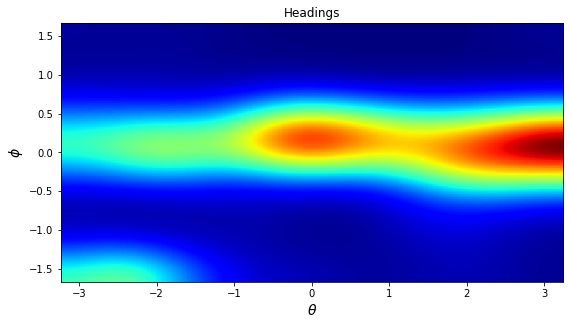

0 --> 10.84


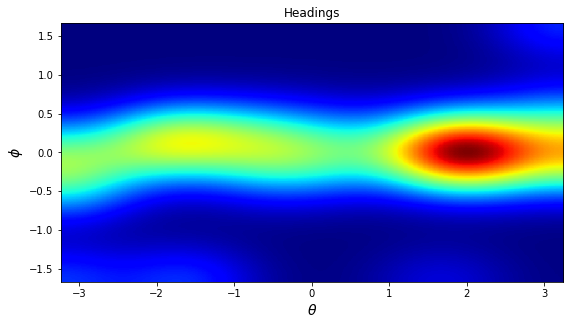

0 --> 11.21


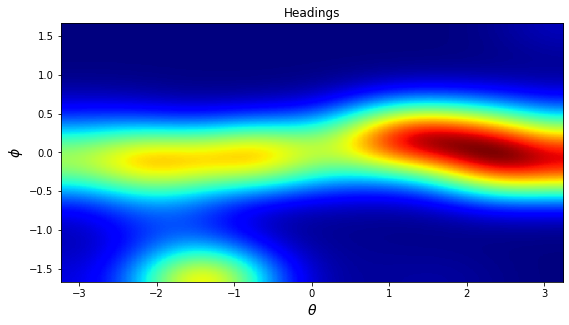

0 --> 10.96


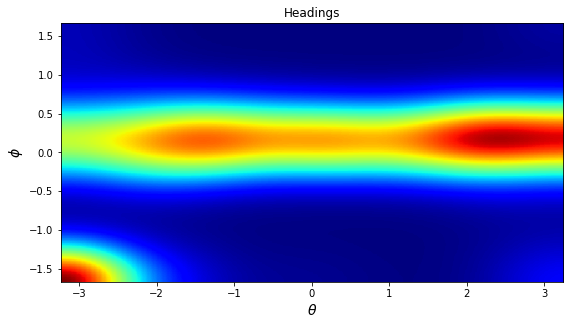

1 --> 11.16


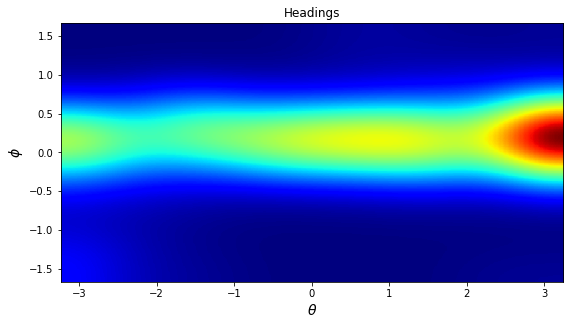

1 --> 10.88


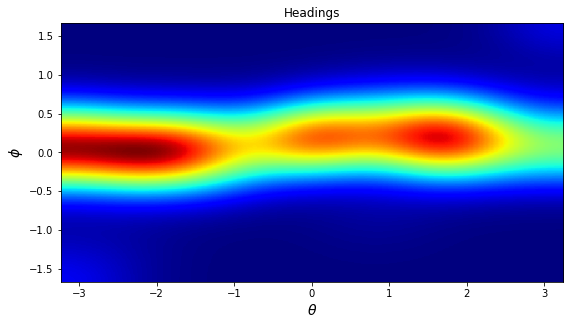

2 --> 11.07


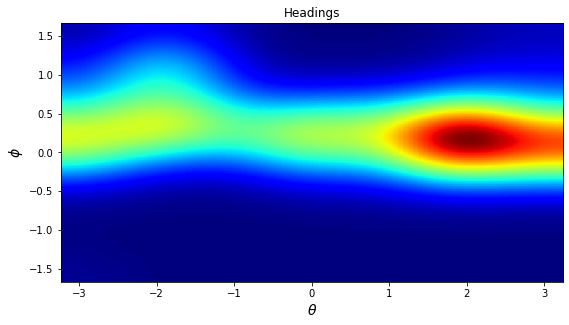

1 --> 11.01


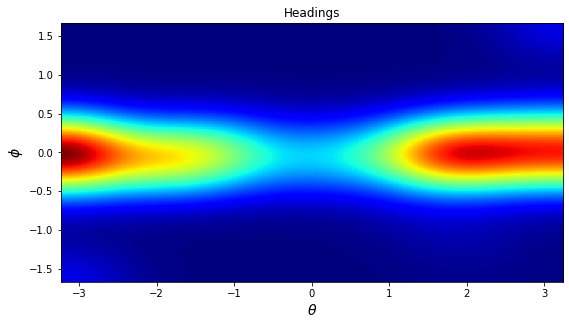

0 --> 10.82


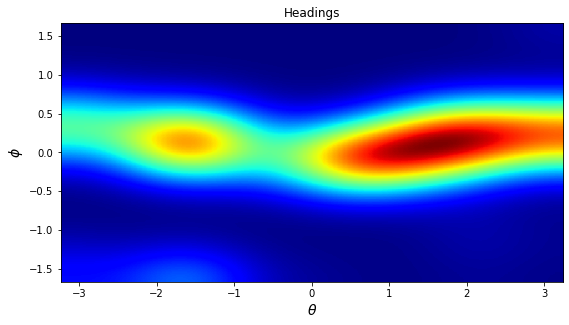

1 --> 10.87


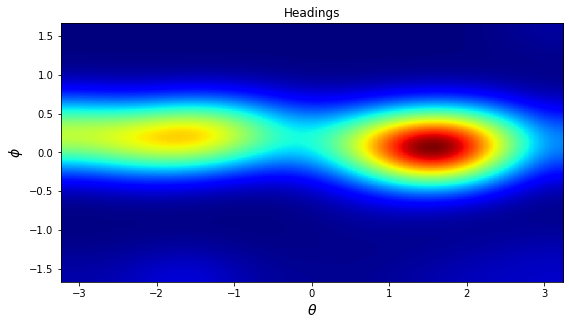

1 --> 10.61


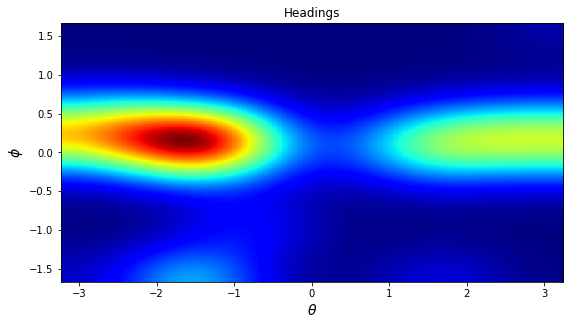

2 --> 11.0


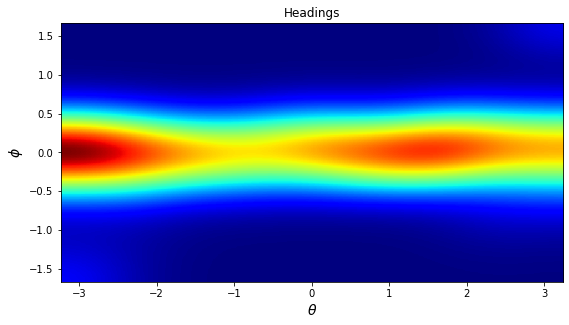

1 --> 10.97


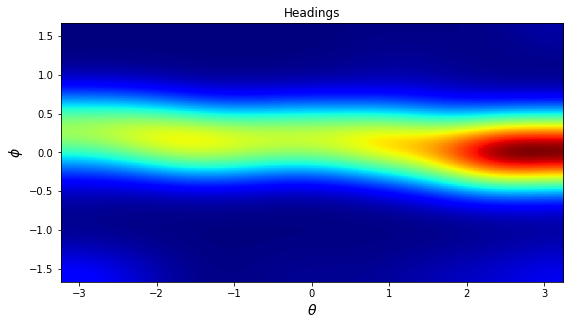

0 --> 11.07


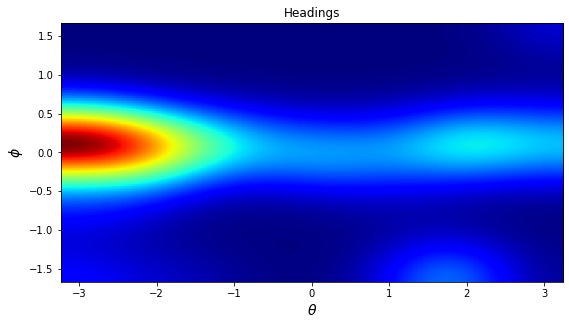

1 --> 10.78


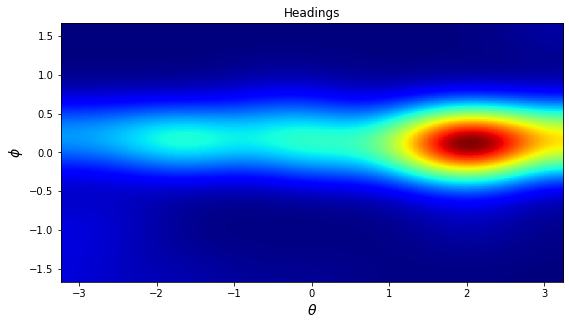

0 --> 11.09


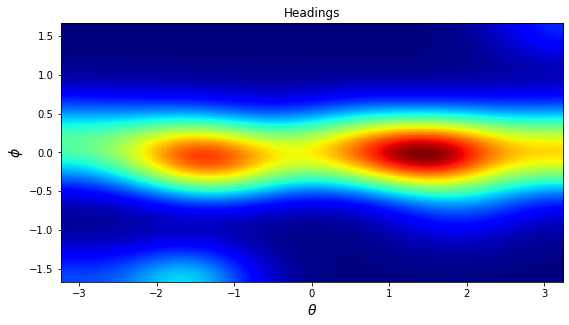

2 --> 11.03


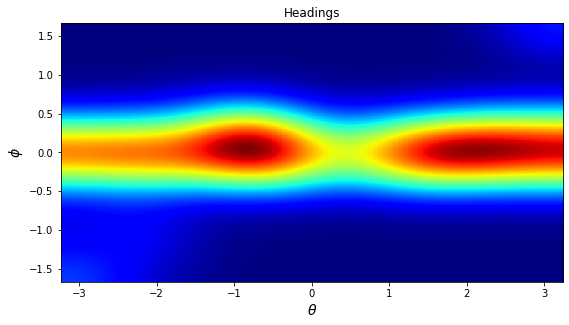

1 --> 11.07


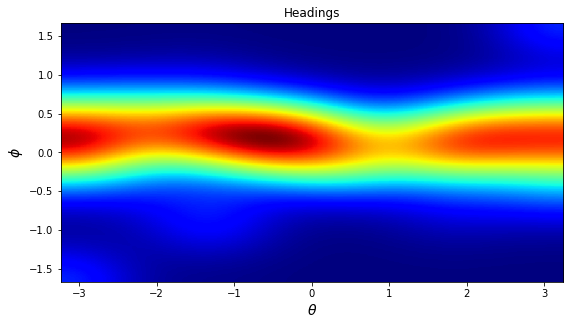

2 --> 11.1


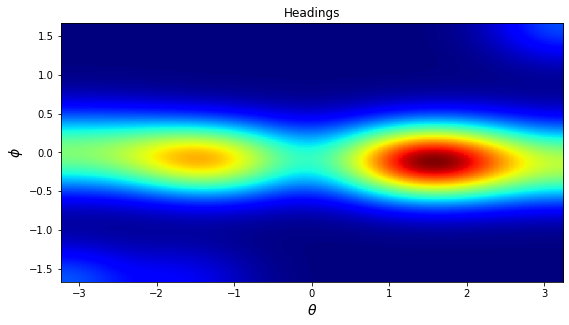

1 --> 10.84


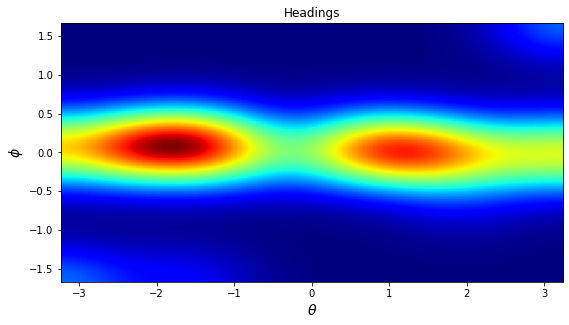

2 --> 10.76


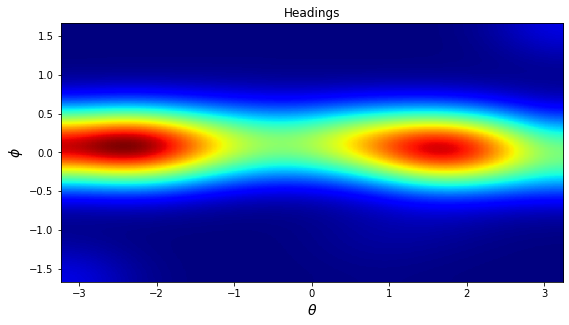

2 --> 11.05


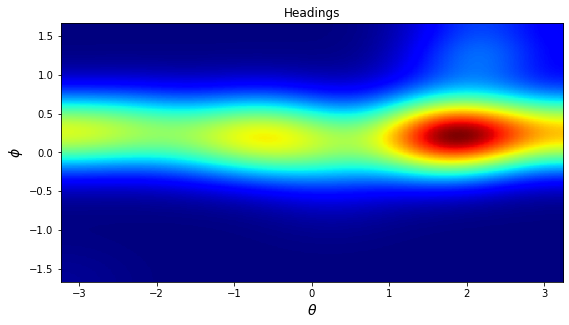

2 --> 11.04


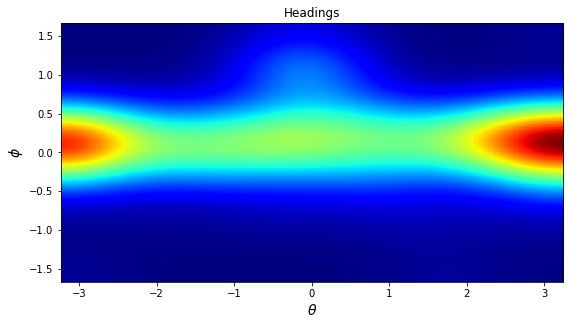

0 --> 10.87


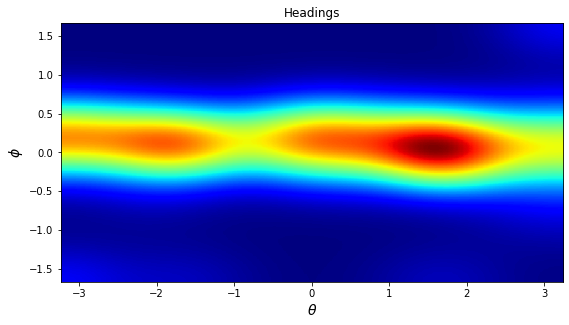

In [62]:
types = []
Hs = []
H2s = []

for h, name in zip(headings_csv, headings):
    h = h.dropna(axis=0)
    split_idx = h[h.progress == 0].index[-1]

    exp_type = name.replace('_old', '').split('_')[-1].replace('.csv', '')
    H = calculate_entropy(h[split_idx:].x, h[split_idx:].z, h[split_idx:].y)
    print(exp_type, '-->', np.round(H,2))
    
    t, p = cart_to_spherical(h.x, h.z, h.y)
    theta2 = (t + np.pi/2 + np.pi/2) % np.pi - np.pi/2
    
    theta2 = theta2.append(pd.Series([-np.pi/2, np.pi/2]))
    phi = p.append(pd.Series([-np.pi, np.pi]))
    
    img, extent = heading_heatmap(phi, theta2, 10, bins=100)
    plt.figure(figsize=(9, 5))
    plt.title('Headings')
    plt.xlabel(r'$\theta$', fontsize=14)
    plt.ylabel(r'$\phi$', fontsize=14)
    plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    plt.show()
    
    types.append(float(exp_type))
    Hs.append(H)
    H2s.append(stats.entropy(img.sum(axis=0)))

In [63]:
entropies = pd.DataFrame(np.array([types, Hs, H2s]).T,columns=['group', 'H', 'H2'])

In [64]:
entropies.groupby('group')['H'].count()

group
0.0    10
1.0     9
2.0     9
Name: H, dtype: int64

In [65]:
entropies.groupby('group')['H'].mean()

group
0.0    10.995370
1.0    10.909669
2.0    10.978645
Name: H, dtype: float64

In [66]:
entropies.groupby('group')['H'].std()

group
0.0    0.167009
1.0    0.163347
2.0    0.144637
Name: H, dtype: float64

In [67]:
g1 = entropies[entropies['group'] == 0]['H'].values
g2 = entropies[entropies['group'] == 1]['H'].values
g3 = entropies[entropies['group'] == 2]['H'].values
f_oneway(g1, g2, g3)

F_onewayResult(statistic=0.7571264781283168, pvalue=0.4794658358284811)

In [68]:
entropies.groupby('group')['H2'].mean()

group
0.0    4.573740
1.0    4.565837
2.0    4.573910
Name: H2, dtype: float64

In [69]:
entropies.groupby('group')['H2'].std()

group
0.0    0.032585
1.0    0.029982
2.0    0.021802
Name: H2, dtype: float64

In [70]:
g1_2 = entropies[entropies['group'] == 0]['H2'].values
g2_2 = entropies[entropies['group'] == 1]['H2'].values
g3_2 = entropies[entropies['group'] == 2]['H2'].values
f_oneway(g1_2, g2_2, g3_2)

F_onewayResult(statistic=0.23685907538820045, pvalue=0.790853182777475)